In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import re
import string
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
    
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, Conv1D, Dense, Dropout, Attention, Bidirectional
from tensorflow.keras.callbacks import TensorBoard


import nltk
nltk.download('stopwords')
log_dir = "logs/"  # Especifique o diretório onde os logs serão armazenados
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gyova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('../data/dataset1.csv')
df = df.drop(columns=['index'])

df.isnull().any()

label                False
preprocessed_news    False
dtype: bool

In [3]:
stop_words = set(stopwords.words('portuguese'))

def remover_stop_words(news):
    palavras = news.split()
    palavras_sem_stop = [palavra for palavra in palavras if palavra.lower() not in stop_words]
    return ' '.join(palavras_sem_stop)

def review_cleaning(text):
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df["preprocessed_news"] = df["preprocessed_news"].apply(remover_stop_words)



In [4]:
df['label'] = df.apply(lambda row: 0 if row.label == 'fake' else 1, axis=1)

X = df.drop(['label'], axis = 1)
Y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 10, stratify=Y)
X_train = X_train['preprocessed_news'].apply(lambda x: x.lower())
X_test = X_test['preprocessed_news'].apply(lambda x: x.lower())

In [5]:
train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>',num_words=8000)
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index
train_sequences = train_tokenizer.texts_to_sequences(X_train)

text_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>',num_words=8000)
text_tokenizer.fit_on_texts(X_test.values)
text_word_index = text_tokenizer.word_index
text_sequences = text_tokenizer.texts_to_sequences(X_test)

vocab_length = len(train_word_index) + 1
maxlen=400
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(text_sequences, maxlen=maxlen)

train_padded_seqeunces = train_padded_seqeunces[:, :, tf.newaxis]
test_padded_seqeunces = test_padded_seqeunces[:, :, tf.newaxis]



In [6]:
print(f'Vocab length {vocab_length}, Train sequences {len(train_sequences)}, Test sequences {len(text_sequences)}')


Vocab length 68385, Train sequences 5040, Test sequences 2160


#### HAN

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
output_dim = 64 

def word_attention(x):
    return Attention()([x, x])

def sentence_attention(x):
    return Attention()([x, x])



document_input = Input(shape=(maxlen,))
word_embedding = Embedding(vocab_length, output_dim, input_length=maxlen)(document_input)
word_lstm = Bidirectional(LSTM(50, return_sequences=True))(word_embedding)
word_attention = word_attention(word_lstm)
sentence_lstm = Bidirectional(LSTM(20, return_sequences=True))(word_attention)
sentence_attention = sentence_attention(sentence_lstm)
doc_lstm = Bidirectional(LSTM(10))(sentence_attention)
dense_layer = Dense(5, activation='relu')(doc_lstm)
dropout_layer = tf.keras.layers.Dropout(0.5)(dense_layer)

# Saída final
output = Dense(1, activation='sigmoid')(dropout_layer)

# Crie e compile o modelo
model_han = tf.keras.Model(inputs=document_input, outputs=output)
model_han.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Imprima o resumo do modelo
model_han.summary()

historyHAN = model_han.fit(train_padded_seqeunces, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping,tensorboard_callback])
HAN_train = round(historyHAN.history['accuracy'][-1] * 100, 2)
model_han.save('modelHANV4.keras', save_format='tf')


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 400, 64)              4376640   ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 400, 100)             46000     ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 attention (Attention)       (None, 400, 100)             0         ['bidirectional[0][0]',   

68/68 [==============================] - 9s 116ms/step
              precision    recall  f1-score   support

           0       0.97      0.78      0.86      1080
           1       0.81      0.97      0.89      1080

    accuracy                           0.88      2160
   macro avg       0.89      0.88      0.87      2160
weighted avg       0.89      0.88      0.87      2160



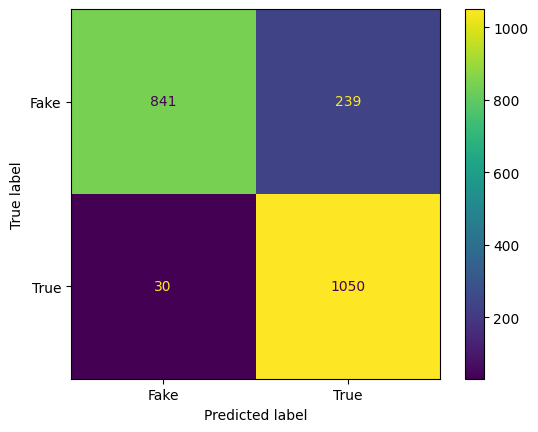

In [8]:
y_test_pred = model_han.predict(test_padded_seqeunces)

y_test_pred = (y_test_pred > 0.70)

    
han_acc = round(accuracy_score(y_test, y_test_pred), 2)

cm = confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()

In [9]:

X = X['preprocessed_news'].apply(lambda x: x.lower())

all_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>',num_words=8000)
all_tokenizer.fit_on_texts(X.values[:10])
all_word_index = all_tokenizer.word_index
all_sequences = all_tokenizer.texts_to_sequences(X.values[:10])

maxlen=400
all_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(all_sequences, maxlen=maxlen)

all_padded_seqeunces = all_padded_seqeunces[:, :, tf.newaxis]


y_all_pred = model_han.predict(all_padded_seqeunces)

y_all_pred = (y_all_pred > 0.70)

y_all_pred

1/1 [==============================] - 0s 74ms/step


array([[ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False]])

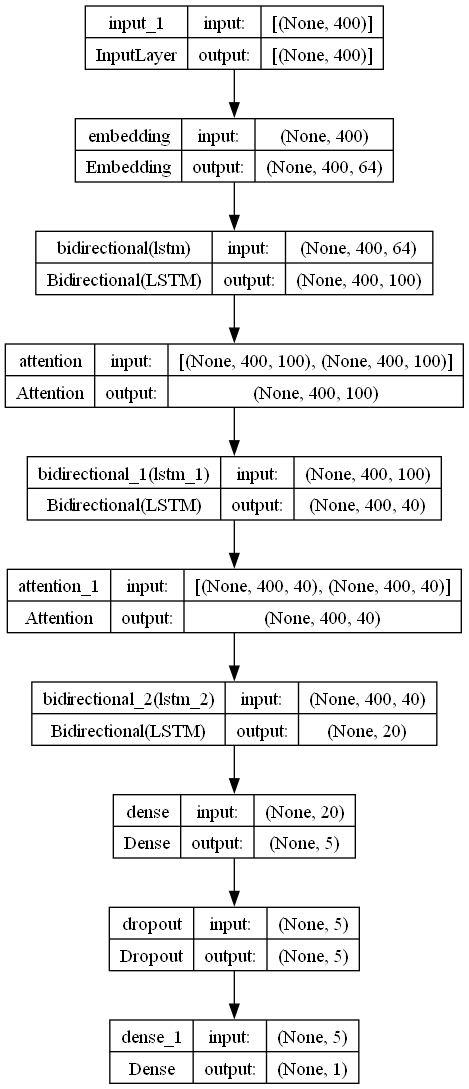

In [10]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model_han, to_file='../summery/han.png', show_shapes=True, show_layer_names=True)
